In this notebook, we will demonstrate that we can use the NTK to well-approximate an over-parameterized network initialized via the NTK scheme. We showcase the result upon training a 1-hidden layer FCNN of width $1024$ on two examples from CIFAR10. We load and visualize the data below.

In [1]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

path = '~/datasets/'

trainset = torchvision.datasets.CIFAR10(root=path,
                                        train=True,
                                        transform=transform,
                                        download=True)

testset = torchvision.datasets.CIFAR10(root=path,
                                        train=False,
                                        transform=transform,
                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


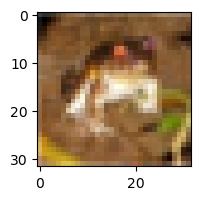

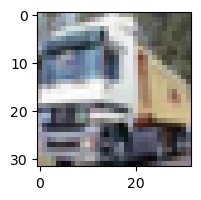

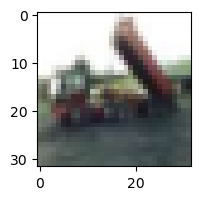

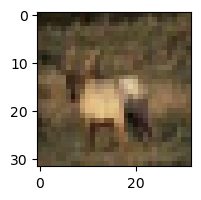

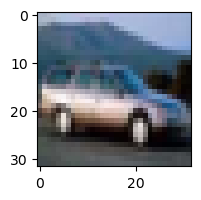

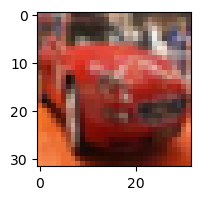

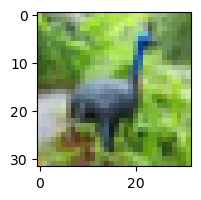

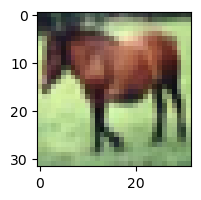

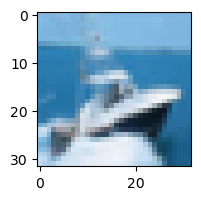

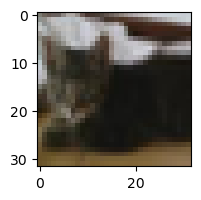

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_samples(trainset, indices):
    for idx in indices:
        img, label = trainset[idx]
        plt.figure(figsize=(2,2))
        plt.imshow(torch.permute(img, (1, 2, 0)))
        
visualize_samples(trainset, list(np.arange(10)))

Note that in the code below, we normalize the images to the unit sphere.  This is to ensure that the loss at initialization is at a reasonable scale for the neural network.  

In [3]:
from torch.linalg import norm 

SEED = 1717
NUM_CLASSES = 10
np.random.seed(SEED)

def subset_indices(dataset, num_samples=1000):
    labelset = {}
    for i in range(NUM_CLASSES):
        one_hot = torch.zeros(NUM_CLASSES)
        one_hot[i] = 1
        labelset[i] = one_hot
        
    all_indices = list(np.arange(len(dataset)))
    subset_idxs = np.random.choice(all_indices, replace=False, size=num_samples) 
    Xs = []
    ys = []
    subset = []
    for idx in subset_idxs:
        img, label = dataset[idx]
        img = img.reshape(-1) / norm(img)
        subset.append((img, labelset[label]))
        Xs.append(img)
        ys.append(labelset[label])
    return subset, np.stack(Xs), np.stack(ys)

train_subset, train_X, train_y = subset_indices(trainset, num_samples=2)
test_subset, test_X, test_y = subset_indices(testset, num_samples=10000)

In [4]:
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(2, 3072) (10000, 3072) (2, 10) (10000, 10)


We first train a fully connected network to interpolate the training data.  In particular, we train the network for $100$ epochs using stochastic gradient descent, and the resulting loss is around $10^{-8}$.  

In [5]:
from torch.utils.data import DataLoader

# Set up data loaders for training neural networks
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(test_subset, batch_size=128, shuffle=False, num_workers=1)

An important difference between our usual networks and the network below is the scaling factor of $\frac{\sqrt{2}}{\sqrt{k}}$.  This scaling factor is necessary when we initialize all weights according to the standard normal distribution $\mathcal{N}(0, 1)$. 

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# I typically abstract away nonlinearity so that I can change it easily if needed
class Nonlinearity(nn.Module):
    def __init__(self):
        super(Nonlinearity, self).__init__()

    def forward(self, x):
        return F.relu(x)

# Build a simple 1 hidden layer FC net.  
class Net(nn.Module):

    def __init__(self, input_dim, target_dim):
        super(Net, self).__init__()
        bias = False
        k = 1024
        self.input_dim = input_dim
        self.target_dim = target_dim
        self.width = k
        self.fc = nn.Sequential(nn.Linear(input_dim, k, bias=bias),
                                Nonlinearity(),
                                nn.Linear(k, target_dim, bias=bias))

    def forward(self, x):
        return self.fc(x) * np.sqrt(2) / np.sqrt(self.width)

Note that in the code below, we are modifying the initialization scheme to use a standard normal initialization for all weights.  We will also keep a copy of the network at initialization (denoted ```net_0```).  This will be important for correcting for constant terms in the NTK.  

In [7]:
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm 
from copy import deepcopy

def train_network(trainloader, testloader, num_epochs=100):

    for idx, batch in enumerate(train_loader):
        inputs, labels = batch
        _, input_dim = inputs.shape
        _, output_dim = labels.shape
        break
    
    net = Net(input_dim, output_dim)
    
    for idx, param in enumerate(net.parameters()):
        init = torch.Tensor(param.size()).normal_().float()
        param.data = init
    
    net_0 = deepcopy(net)
    optimizer = torch.optim.SGD(net.parameters(), lr=1)
    
    train_losses = []
    test_losses = []
    
    for t in tqdm(range(num_epochs)):
        train_loss = train_step(net, optimizer, train_loader)
        test_loss = test_step(net, test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return net, net_0, train_losses, test_losses
        
def train_step(net, optimizer, train_loader):
    net.train()
    criterion = torch.nn.MSELoss(reduction='mean')
    train_loss = 0.
    for batch_idx, batch in enumerate(train_loader):    
        optimizer.zero_grad()
        inputs, targets = batch 
        output = net(Variable(inputs))
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data.numpy() * len(inputs)
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

def test_step(net, test_loader):
    net.eval()
    criterion = torch.nn.MSELoss(reduction='mean')
    test_loss = 0.
    for batch_idx, batch in enumerate(test_loader):    
        inputs, targets = batch 
        with torch.no_grad():
            output = net(Variable(inputs))
        loss = criterion(output, targets)
        test_loss += loss.cpu().data.numpy() * len(inputs)
    test_loss = test_loss / len(test_loader.dataset)
    return test_loss

In [8]:
num_epochs = 100
net, net_0, train_losses, test_losses = train_network(train_loader, test_loader, num_epochs=num_epochs)

100%|███████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


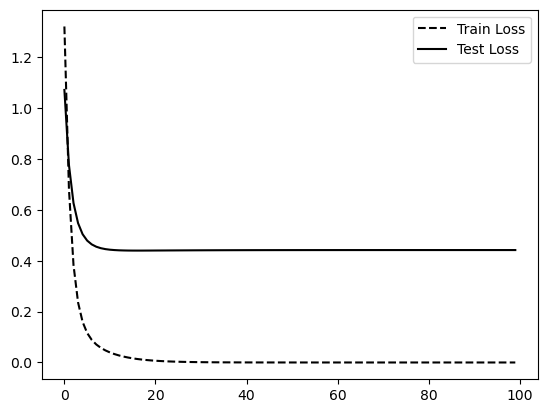

Final Train Loss:  1.2406050409197178e-08


In [9]:
epochs = list(range(num_epochs))
plt.plot(epochs, train_losses, 'k--', label='Train Loss')
plt.plot(epochs, test_losses, 'k-', label='Test Loss')
plt.legend()
plt.show()
print("Final Train Loss: ", train_losses[-1])

We now need to extract the training predictions and test predictions of our network at initialization in order to account for this offset in the NTK. 

In [13]:
@torch.no_grad()
def get_nn_preds(net, loader):
    preds = []
    for idx, batch in enumerate(loader):
        inputs, labels = batch
        out = net(inputs).data.numpy()
        preds.append(out)
    return np.concatenate(preds, axis=0)
nn_train_preds = get_nn_preds(net, train_loader)
nn_test_preds = get_nn_preds(net, test_loader)
nn_test_init_preds = get_nn_preds(net_0, test_loader)
nn_train_init_preds = get_nn_preds(net_0, train_loader)

We then leverage our usual NTK code for computing the kernel.

In [14]:
from numpy.linalg import solve

def relu_ntk(X, Z, depth=2, bias=0):
    from torch import acos
    pi = np.pi
    kappa_0 = lambda u: (1-acos(u)/pi)
    kappa_1 = lambda u: u*kappa_0(u) + (1-u.pow(2)).sqrt()/pi
    Z = Z if Z is not None else X
    eps = 0
    norm_x = X * X
    norm_x = torch.sqrt(torch.sum(norm_x, dim=1, keepdim=True))
    norm_z = Z * Z
    norm_z = torch.sqrt(torch.sum(norm_z, dim=1, keepdim=True).T)
    S = X @  Z.T

    N = S + bias**2

    for k in range(1, depth):
        in_ = (S/norm_x/norm_z).clip(-1+eps,1-eps)
        S = norm_x*norm_z*kappa_1(in_)
        N = N * kappa_0(in_) + S + bias**2
    return N, S

class ReLU_Kernel():

    def __init__(self, depth=2, bias=0, ntk=True):
        self.sol = None
        self.depth = depth
        self.X_train = None
        self.bias=bias
        self.ntk = ntk
        
    def fit(self, X, y, reg=0):
        self.X_train = torch.from_numpy(X)
        N, S = relu_ntk(self.X_train, self.X_train, bias=self.bias, depth=self.depth)
        if self.ntk:
            K = N.numpy()
        else: 
            K = S.numpy()
        sol = solve(K + reg * np.eye(len(K)), y).T
        self.sol = sol
        return self

    def predict(self, X):
        X = torch.from_numpy(X)
        N, S = relu_ntk(self.X_train, X, depth=self.depth, bias=self.bias)
        if self.ntk: 
            K = N.numpy()
        else:
            K = S.numpy()
        return (self.sol @ K).T

If we want the NTK predictions to match the NN predictions, we need to first subtract the training predictions of ```net_0``` from our training labels and then add the corresponding test predictions back at test time.  

In [18]:
model = ReLU_Kernel(depth=2, ntk=True)

model.fit(train_X, train_y - nn_train_init_preds)
train_pred = model.predict(train_X)
test_preds = model.predict(test_X) + nn_test_init_preds

error = np.mean(np.square(test_preds - nn_test_preds))
print("MSE between NTK and NN Test Predictions: ", error)

MSE between NTK and NN Test Predictions:  0.0015188280825034638
